<a href="https://colab.research.google.com/github/Uemerson/masters-degree-in-computer-science-from-unesp/blob/main/masters-degree-in-computer-science-from-unesp/voxelmorph/oasis/max-pooling/100_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
!git clone https://github.com/voxelmorph/voxelmorph.git # getting vxm from git to use scripts
!pip install neurite

Cloning into 'voxelmorph'...
remote: Enumerating objects: 3228, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 3228 (delta 9), reused 12 (delta 5), pack-reused 3202
Receiving objects: 100% (3228/3228), 129.18 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (2075/2075), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.3-py3-none-any.whl size=19549 sha256=db4ca02ad52656e9551edbf38f1e3aea46a50ca418659a9a0e3821e9308d81b2
  Stored in directory: /root/.cache/pip/wheels/33/42/e2/6312e2cd3efadacc2714759efc7c7dc1513db7853e8bd508f6
Successfully built pystrum


In [2]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import sys 
sys.path.append('voxelmorph')
import voxelmorph as vxm

import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

np.random.seed(777)
tf.random.set_seed(777)

# disable eager execution
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True) # https://github.com/tensorflow/tensorflow/issues/54458


# Download dataset OASIS

In [4]:
# get neurite-OASIS data
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
!mkdir OASIS
!tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS'

# !wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar
# !mkdir OASIS
# !tar xf neurite-oasis.v1.0.tar --directory 'OASIS'

--2023-05-03 03:20:35--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘neurite-oasis.2d.v1.0.tar’

neurite-oasis.2d.v1 100%[===================>]  23.75M  19.3MB/s    in 1.2s    

2023-05-03 03:20:37 (19.3 MB/s) - ‘neurite-oasis.2d.v1.0.tar’ saved [24903680/24903680]



In [5]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(subj_lst_m))

# Train (ok)

Epoch 1/100
100/100 [==============================] - 19s 26ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_resize_loss: 1.3033e-04
Epoch 2/100
100/100 [==============================] - 3s 26ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_resize_loss: 5.4878e-04
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0062 - vxm_dense_transformer_loss: 0.0061 - vxm_dense_flow_resize_loss: 0.0138
Epoch 4/100
100/100 [==============================] - 3s 31ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0054 - vxm_dense_transformer_loss: 0.0050 - vxm_dense_flow_resize_loss: 0.0358
Epoch 5/100
100/100 [==============================] - 3s 29ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0050 - vxm_dense_transformer_loss: 0.0046 - vxm_dense_flow_resize_loss: 0.0465
Epoch 6/100
100/100 [=========================

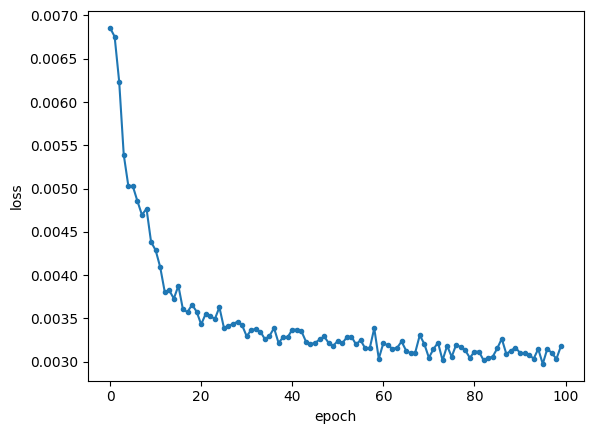

In [6]:
# training parameters
class Args:
  img_list: str = 'train_list.txt'
  img_prefix: str = None
  img_suffix: str = None
  atlas: str = None
  model_dir: str = 'models'
  multichannel: bool = False
  gpu: int = 0
  batch_size: int = 1
  epochs: int = 1500
  steps_per_epoch: int = 100
  load_weights: str = None
  initial_epoch: int = 0
  lr: float = 1e-4
  enc: list = None
  dec: list = None
  int_steps: int = 7
  int_downsize: int = 2
  use_probs: bool = False
  bidir: bool = False
  image_loss: str = 'mse'
  lambda_weight: float = 0.01
  kl_lambda: float = 10
  image_sigma: float = 1.0

args = Args()
args.epochs = 100

# load and prepare training data
train_files = vxm.py.utils.read_file_list(args.img_list, prefix=args.img_prefix,
                                          suffix=args.img_suffix)
assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel

if args.atlas:
    # scan-to-atlas generator
    atlas = vxm.py.utils.load_volfile(args.atlas, np_var='vol',
                                      add_batch_axis=True, add_feat_axis=add_feat_axis)
    generator = vxm.generators.scan_to_atlas(train_files, atlas,
                                             batch_size=args.batch_size,
                                             bidir=args.bidir,
                                             add_feat_axis=add_feat_axis)
else:
    # scan-to-scan generator
    generator = vxm.generators.scan_to_scan(
        train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)

# extract shape and number of features from sampled input
sample_shape = next(generator)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

# prepare model folder
model_dir = args.model_dir
os.makedirs(model_dir, exist_ok=True)

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)
assert np.mod(args.batch_size, nb_devices) == 0, \
    'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (args.batch_size, nb_devices)

# unet architecture
enc_nf = args.enc if args.enc else [16, 32, 32, 32]
dec_nf = args.dec if args.dec else [32, 32, 32, 32, 32, 16, 16]

# prepare model checkpoint save path
save_filename = os.path.join(model_dir, '{epoch:04d}.h5')

# build the model
model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=args.bidir,
    use_probs=args.use_probs,
    int_steps=args.int_steps,
    int_resolution=args.int_downsize,
    src_feats=nfeats,
    trg_feats=nfeats
)

# load initial weights (if provided)
if args.load_weights:
    model.load_weights(args.load_weights)

# prepare image loss
if args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE(args.image_sigma).loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if args.bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]

# prepare deformation loss
if args.use_probs:
    flow_shape = model.outputs[-1].shape[1:-1]
    losses += [vxm.losses.KL(args.kl_lambda, flow_shape).loss]
else:
    losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]

weights += [args.lambda_weight]

# multi-gpu support
if nb_devices > 1:
    save_callback = vxm.networks.ModelCheckpointParallel(save_filename)
    model = tf.keras.utils.multi_gpu_model(model, gpus=nb_devices)
else:
    save_callback = tf.keras.callbacks.ModelCheckpoint(save_filename, 
                                                       save_freq=20 * args.steps_per_epoch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=args.lr), loss=losses, loss_weights=weights)

# save starting weights
# model.save(save_filename.format(epoch=args.initial_epoch))

hist = model.fit(generator,
         initial_epoch=args.initial_epoch,
         epochs=args.epochs,
         steps_per_epoch=args.steps_per_epoch,
         callbacks=[save_callback],
         verbose=1
        )

# plot training history.
plt.figure()
plt.plot(hist.epoch, hist.history['loss'], '.-')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Registration (ok)

In [51]:
from matplotlib.image import NonUniformImage
class Args:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

args = Args()
args.moving = '/content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz'
args.fixed = '/content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz'
args.moved = 'moved.nii.gz'
args.warp = 'warp.nii.gz'
args.model = '/content/models/0100.h5'
args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)

# load moving and fixed images
add_feat_axis = not args.multichannel
moving = vxm.py.utils.load_volfile(args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)
fixed, fixed_affine = vxm.py.utils.load_volfile(
    args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

# save warp
if args.warp:
    vxm.py.utils.save_volfile(warp.squeeze(), args.warp, fixed_affine)

# save moved image
vxm.py.utils.save_volfile(moved.squeeze(), args.moved, fixed_affine)


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


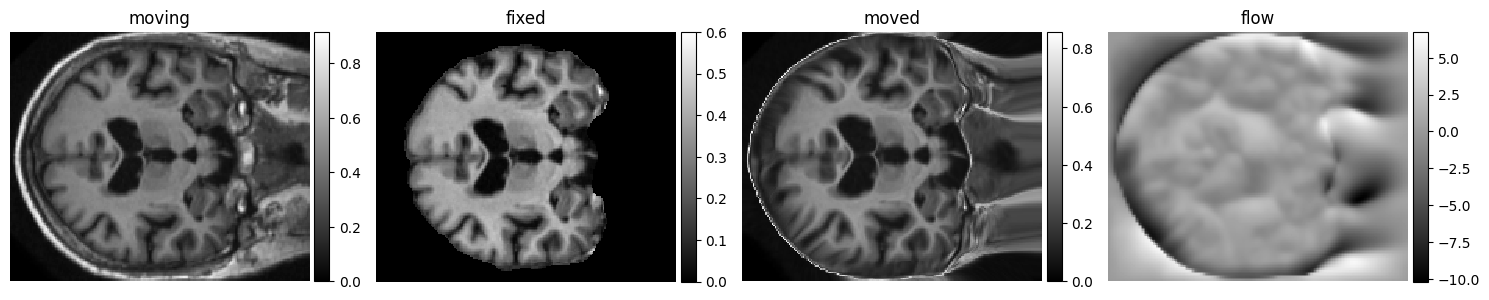

In [71]:
# visualize registration
images = [img[0, :, :, 0] for img in [moving, fixed, moved, warp]]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

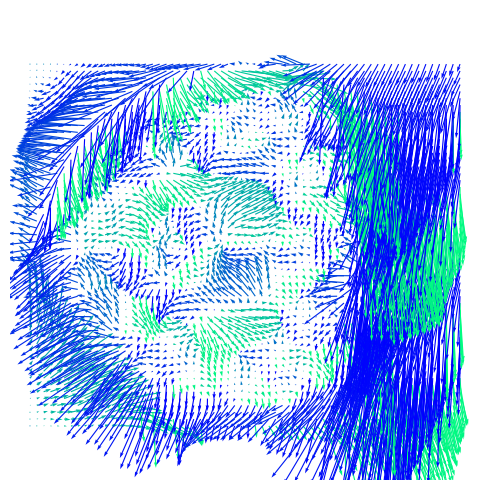

In [81]:
# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Testing (measuring Dice scores)

In [ ]:
%run -i /content/voxelmorph/scripts/tf/test.py \
--model /content/models/0100.h5 \
--pairs /content/pairs.txt \
--img-prefix /content/OASIS/  \
--seg-prefix /content/OASIS/  \
--img-suffix /slice_norm.nii.gz  \
--seg-suffix /slice_seg24.nii.gz

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Pair 1    Reg Time: 4.6393    Dice: 0.6047 +/- 0.3012
Pair 2    Reg Time: 0.0589    Dice: 0.6481 +/- 0.3133

Avg Reg Time: 0.0589 +/- 0.0000  (skipping first prediction)
Avg Dice: 0.6264 +/- 0.0217


# Some annotations

Explain of testing script:

https://github.com/voxelmorph/voxelmorph/issues/373